# Part 2

This notebook will answer all the questions in part 2

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Dataset Preparation 

First, we define all relevant hyperparameters, then we load the dataset.

After which, we will load the word embeddings and process the data accordingly

In [2]:
BATCH_SIZE = 32

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

### Word Embedding

We load the pre-trained Google News 300 dimension Word2Vec model and obtain a word index to be used later in data processing

In [4]:
word2vec_model = load_word2vec()

In [5]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

### Dataloaders

Once we have the dataset and the word index both loaded, we can proceed with building the dataloaders for batch training. We first prepare the data by tokenizing and padding the data so that they are all of the same length

In [6]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

Once the data is processed, we create dataloaders for the data for batch training

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

## Model

Once again, we define all relevant hyperparameters

In [8]:
LR = 0.0001
MODEL_TYPE = "rnn"

### 1. Default RNN

We initialise the model for the default RNN without any extra processing to derive the final sentence representation

In [9]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [10]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode=None
)

Epoch   1/100, Loss: 0.6403, Accuracy: 0.7326
Model saved.
Epoch   2/100, Loss: 0.5293, Accuracy: 0.7523
Model saved.
Epoch   3/100, Loss: 0.5172, Accuracy: 0.7373
Epoch   4/100, Loss: 0.5025, Accuracy: 0.7552
Model saved.
Epoch   5/100, Loss: 0.4946, Accuracy: 0.7477
Epoch   6/100, Loss: 0.4912, Accuracy: 0.7505
Epoch   7/100, Loss: 0.4884, Accuracy: 0.7430
Epoch   8/100, Loss: 0.4732, Accuracy: 0.7495
Epoch   9/100, Loss: 0.4628, Accuracy: 0.7326
Epoch  10/100, Loss: 0.4513, Accuracy: 0.7167
Epoch  11/100, Loss: 0.4354, Accuracy: 0.7364
Epoch  12/100, Loss: 0.4220, Accuracy: 0.7430
Epoch  13/100, Loss: 0.4118, Accuracy: 0.7223
Epoch  14/100, Loss: 0.3997, Accuracy: 0.7129
Early stopping triggered after 14 epochs.
Training ended, loading best model...
Model loaded.


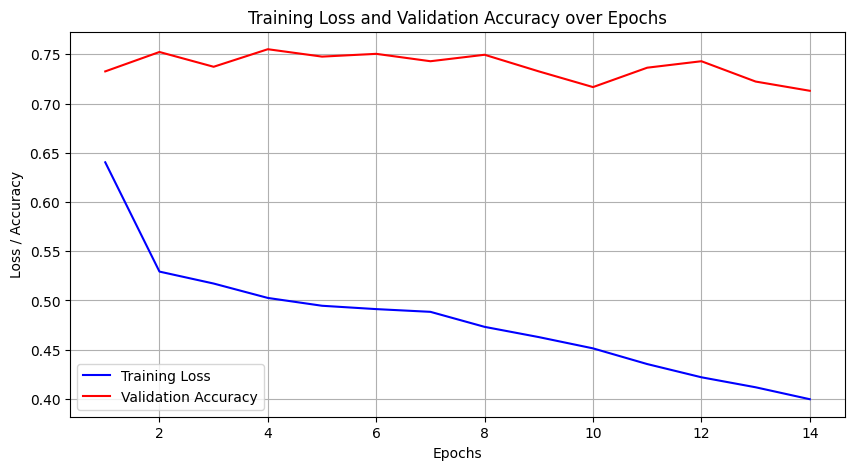

In [11]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [12]:
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7552


Test the model on the test set to obtain the accuracy

In [13]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7392


### 2. Last State RNN

This RNN will pick the hidden vector from the last time step as the sentence representation. This approach assumes that the last hidden state will capture the overall meaning of the sentence

In [14]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [15]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state" # train only the last state
)

Epoch   1/100, Loss: 0.6688, Accuracy: 0.6932
Model saved.
Epoch   2/100, Loss: 0.5355, Accuracy: 0.7420
Model saved.
Epoch   3/100, Loss: 0.5146, Accuracy: 0.7439
Model saved.
Epoch   4/100, Loss: 0.5035, Accuracy: 0.7308
Epoch   5/100, Loss: 0.4980, Accuracy: 0.7486
Model saved.
Epoch   6/100, Loss: 0.4915, Accuracy: 0.7373
Epoch   7/100, Loss: 0.4818, Accuracy: 0.7505
Model saved.
Epoch   8/100, Loss: 0.4739, Accuracy: 0.7552
Model saved.
Epoch   9/100, Loss: 0.4660, Accuracy: 0.7580
Model saved.
Epoch  10/100, Loss: 0.4576, Accuracy: 0.7467
Epoch  11/100, Loss: 0.4501, Accuracy: 0.7373
Epoch  12/100, Loss: 0.4385, Accuracy: 0.7448
Epoch  13/100, Loss: 0.4317, Accuracy: 0.7214
Epoch  14/100, Loss: 0.4204, Accuracy: 0.7167
Epoch  15/100, Loss: 0.4087, Accuracy: 0.7242
Epoch  16/100, Loss: 0.4015, Accuracy: 0.7298
Epoch  17/100, Loss: 0.3857, Accuracy: 0.7261
Epoch  18/100, Loss: 0.3786, Accuracy: 0.7364
Epoch  19/100, Loss: 0.3688, Accuracy: 0.7101
Early stopping triggered after 19 e

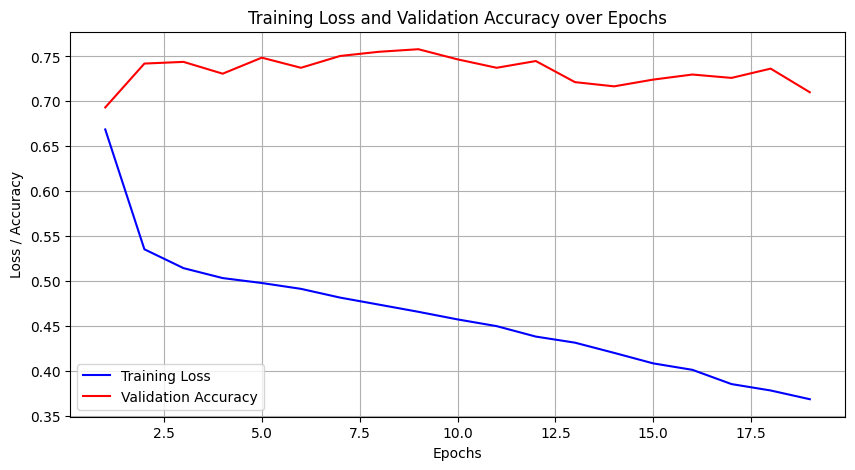

In [16]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [17]:
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7580


Test the model on the test set to obtain the accuracy

In [18]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7345


### 3. Mean Pooling RNN

This RNN will use the average of all hidden vectors as the sentence representation. This captures information across the whole sentence by averaging the all the words' contributions

In [19]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [20]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool" # train only the mean pool
)

Epoch   1/100, Loss: 0.6588, Accuracy: 0.7205
Model saved.
Epoch   2/100, Loss: 0.5311, Accuracy: 0.7552
Model saved.
Epoch   3/100, Loss: 0.5116, Accuracy: 0.7448
Epoch   4/100, Loss: 0.5031, Accuracy: 0.7523
Epoch   5/100, Loss: 0.4955, Accuracy: 0.7552
Epoch   6/100, Loss: 0.4900, Accuracy: 0.7448
Epoch   7/100, Loss: 0.4822, Accuracy: 0.7523
Epoch   8/100, Loss: 0.4765, Accuracy: 0.7589
Model saved.
Epoch   9/100, Loss: 0.4664, Accuracy: 0.7664
Model saved.
Epoch  10/100, Loss: 0.4542, Accuracy: 0.7617
Epoch  11/100, Loss: 0.4471, Accuracy: 0.7336
Epoch  12/100, Loss: 0.4316, Accuracy: 0.7392
Epoch  13/100, Loss: 0.4202, Accuracy: 0.7458
Epoch  14/100, Loss: 0.4074, Accuracy: 0.7205
Epoch  15/100, Loss: 0.4008, Accuracy: 0.7326
Epoch  16/100, Loss: 0.3871, Accuracy: 0.7176
Epoch  17/100, Loss: 0.3770, Accuracy: 0.7186
Epoch  18/100, Loss: 0.3693, Accuracy: 0.7214
Epoch  19/100, Loss: 0.3581, Accuracy: 0.7298
Early stopping triggered after 19 epochs.
Training ended, loading best mod

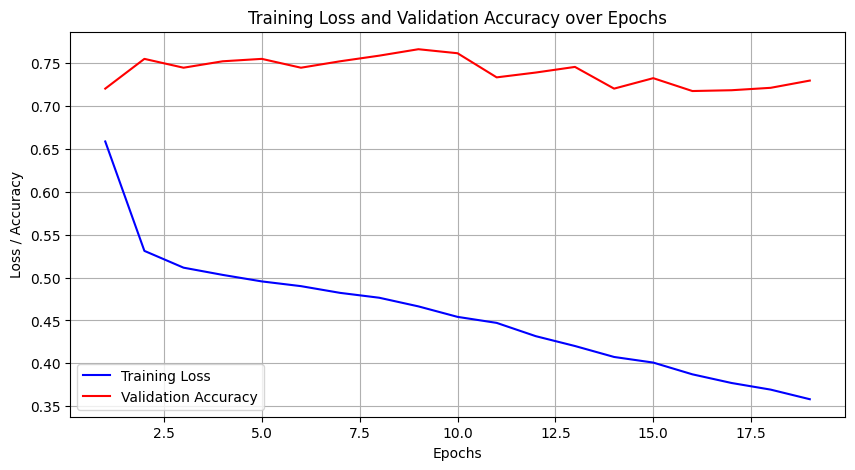

In [21]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [22]:
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7664


Test the model on the test set to obtain the accuracy

In [23]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7392


### 4. Max Pool RNN

This RNN will compute the max of all hidden vectors along each dimension. This will effectively use the most significant word as the representation of the sentence

In [24]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [25]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool" # train only the max pool
)

Epoch   1/100, Loss: 0.6517, Accuracy: 0.7026
Model saved.
Epoch   2/100, Loss: 0.5343, Accuracy: 0.7533
Model saved.
Epoch   3/100, Loss: 0.5124, Accuracy: 0.7505
Epoch   4/100, Loss: 0.5029, Accuracy: 0.7430
Epoch   5/100, Loss: 0.4965, Accuracy: 0.7552
Model saved.
Epoch   6/100, Loss: 0.4897, Accuracy: 0.7533
Epoch   7/100, Loss: 0.4843, Accuracy: 0.7552
Epoch   8/100, Loss: 0.4776, Accuracy: 0.7580
Model saved.
Epoch   9/100, Loss: 0.4668, Accuracy: 0.7514
Epoch  10/100, Loss: 0.4587, Accuracy: 0.7467
Epoch  11/100, Loss: 0.4461, Accuracy: 0.7355
Epoch  12/100, Loss: 0.4348, Accuracy: 0.7317
Epoch  13/100, Loss: 0.4275, Accuracy: 0.7214
Epoch  14/100, Loss: 0.4093, Accuracy: 0.7195
Epoch  15/100, Loss: 0.3966, Accuracy: 0.7186
Epoch  16/100, Loss: 0.3895, Accuracy: 0.7233
Epoch  17/100, Loss: 0.3733, Accuracy: 0.7017
Epoch  18/100, Loss: 0.3626, Accuracy: 0.7073
Early stopping triggered after 18 epochs.
Training ended, loading best model...
Model loaded.


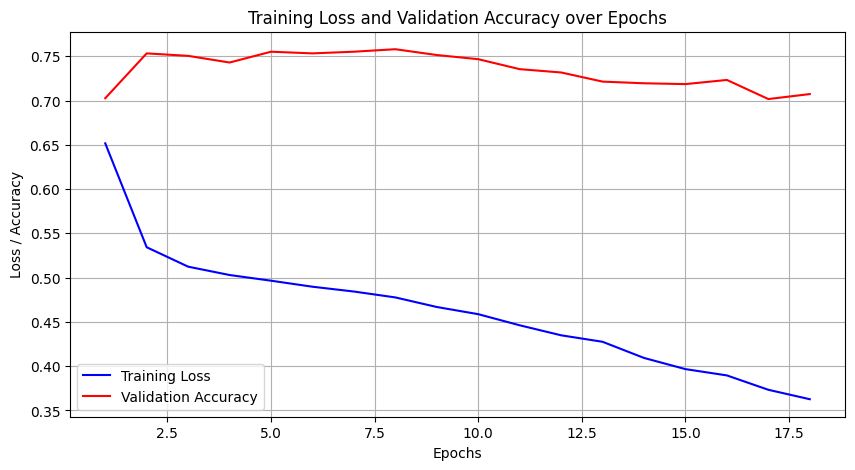

In [26]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [27]:
val_accuracy = validate(model, val_dataloader)

Accuracy: 0.7580


Test the model on the test set to obtain the accuracy

In [28]:
tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7486


## Results

Based on the 4 visualisations and accuracy values, we can see that the best performing model is the one that uses Max Pooling.